In [18]:
%reload_ext autoreload
%autoreload 2
import torchvision
from fastai import *
from fastai.vision import *
from pathlib import Path
import pretrainedmodels

from utils import *

# from torch.utils.data.sampler import WeightedRandomSampler
from imba_sampler import ImbalancedDatasetSampler

torch.backends.cudnn.benchmark = False

In [19]:
MASKS = 'train.csv'

PATH = Path('./')
TRAIN = Path('train512/')
TEST = Path('test512/')
TRAIN_AUG = Path('../aug/train/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
seg_aug = pd.read_csv('../aug/augment.csv', header=None)
seg_aug.columns = seg.columns
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

classes = [str(l) for l in range(28)]

In [20]:
df = pd.read_csv('aug_train.csv'); len(df)

99165

# Inception

In [21]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [22]:
model = pretrainedmodels.__dict__['inceptionresnetv2'](num_classes=1000, pretrained='imagenet')

In [23]:
# head = nn.Sequential(nn.Linear(2*1536,1000),
#                      nn.ReLU(inplace=True),
#                      nn.BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                      nn.Dropout(p=0.5),
#                      nn.Linear(1000,28))

def head(in_c, out):
    return nn.Sequential(AdaptiveConcatPool2d(),
                         Flatten(),
                         nn.BatchNorm1d(2*in_c, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                         nn.Dropout(p=0.25),
                         nn.Linear(in_features=2*in_c, out_features=in_c, bias=True),
                         nn.ReLU(inplace=True),
                         nn.BatchNorm1d(in_c, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                         nn.Dropout(p=0.5),
                         nn.Linear(in_features=in_c, out_features=out, bias=True)
                        )

In [24]:
cut = -2
body = nn.Sequential(*list(model.children())[:cut])

In [25]:
arch = nn.Sequential(body, 
                     AdaptiveConcatPool2d(),
                     Flatten(),
                     nn.Linear(2*1536, 28, True))

In [26]:
v = torch.rand((4,3,256,256))

In [27]:
out = arch(v); out.shape

torch.Size([4, 28])

In [28]:
stats = ([0.08069, 0.05258, 0.05487], [0.13704,0.10145, 0.15313])
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_lighting=0.1, max_warp=0.4)

In [29]:
def get_data(sz=64, bs=64, pct=0.2, sample=5000):
#     sz, pct, bs = 64, 0.2, 64
    src = (ImageItemList.from_df(df=df, path=PATH, folder=TRAIN_AUG, suffix='.png')
           .random_split_by_pct(pct)
           .label_from_df(sep=' ', classes=classes)
           .add_test([TEST/(f+'.png') for f in test_names]))
    data = (src.transform(tfms, size=sz))
    #         .databunch(bs=bs).normalize(stats))

    test_ds = data.test
    train_ds, val_ds = data.train, data.valid
    datasets = [train_ds,val_ds, test_ds]
    sampler = ImbalancedDatasetSampler(datasets[0], num_samples=sample)
    train_dl = DataLoader(datasets[0], bs, sampler=sampler, num_workers=12)
    val_dl = DataLoader(datasets[1], 2*bs, False, num_workers=8)
    test_dl = DataLoader(datasets[2], 2*bs, False, num_workers=8)

    return ImageDataBunch(train_dl=train_dl, valid_dl=val_dl, test_dl=test_dl).normalize(stats)

In [30]:
def get_learner(data, focal=True, fp16=True):
    learn = Learner(data, arch, metrics=[accuracy_thresh, f1], 
               callback_fns=[partial(GradientClipping, clip=0.1), ShowGraph])
    learn.split((learn.model[1],))
    if focal: learn.loss_func = FocalLoss()
    if fp16: learn.to_fp16();
    return learn.mixup(stack_y=False)

# 256

In [31]:
data = get_data(256, 128, 0.1, sample=None)

In [32]:
learn = get_learner(data, focal=True, fp16=True)

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


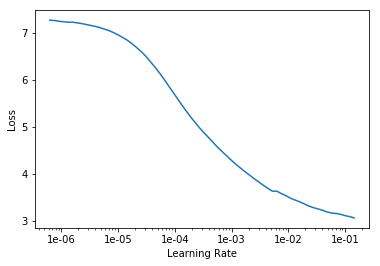

In [18]:
learn.recorder.plot()

In [33]:
lr = 1e-3

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,1.090115,0.993639,0.958599,0.159607


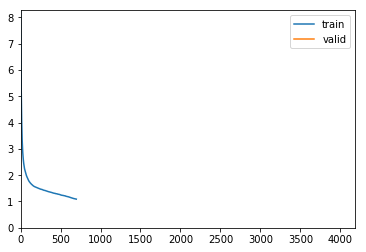

In [ ]:
%time learn.fit_one_cycle(6, slice(lr))

In [ ]:
learn.save('incepresnet_256_1');

In [ ]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(6, slice(lr/10,lr/5))

In [ ]:
learn.save('incepresnet_256_2');

In [ ]:
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

In [17]:
p.shape

torch.Size([11702, 28])

# Sub File

In [18]:
model_name = 'inv4'

In [19]:
preds = to_np(p.sigmoid())  #Check if we are using focal loss or BCE.
threshold = 0.4 #ths
print(preds.shape)
classes = np.array(data.classes)
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

(11702, 28)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


In [20]:
preds = to_np(p.sigmoid())  #Check if we are using focal loss or BCE.
np.save(model_name, preds)

In [21]:
frame = pd.DataFrame(np.array([test_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv(f'{model_name}.csv', index=False)

In [22]:
frame.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,


In [ ]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f "inv4.csv" -m "inception V4 sz=299"